In [1]:
import cPickle as pkl
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

'''
import random
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
'''

'\nimport random\nimport pandas as pd\nfrom statsmodels.nonparametric.smoothers_lowess import lowess\n'

In [2]:
filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"

In [3]:
results = pkl.load(open(filepath))

In [4]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

In [5]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 167.580508475
YAL038W 141.609887006
YJL189W 133.568361582
YCR012W 129.352259887
YOL086C 135.939548023
YLR110C 124.482047516
YLR044C 223.223163842
YKL152C 132.904884319


In [16]:
transcriptome_shah = pkl.load(open('../parameters/transcriptome_shah.p'))

In [17]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.25: 
        print prot, prot_per_transcript_speeds[prot]

YJL158C 0.251702025481
YDR461W 0.267514124294
YDR224C 0.258764371875
YLR388W 0.266384180791


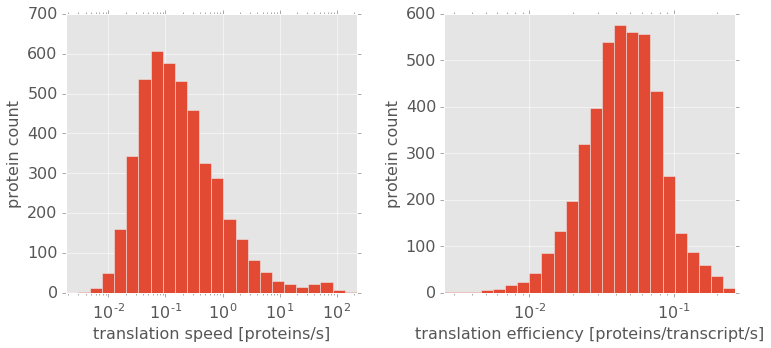

In [35]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(121)
n, bins, patches = ax.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 25))
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

ax = fig.add_subplot(122)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 32))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
plt.gca().set_xlabel('translation efficiency [proteins/transcript/s]', fontsize=16)
plt.gca().set_ylabel('protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.show()